# download sample data from database

In [1]:
import os
os.chdir(r'C:\Users\Jaeho\Desktop\QB_Algo')
import Modules.General.func_DB as GDB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip3 install plotly
import plotly.express as px
from tqdm import tqdm

price = GDB.DB_import_data_bbg('PX', ['SPXT Index','NDDUEAFE Index','NDUEEGF Index','LBUSTRUU Index','SPGSCI Index'])
cols = ['agg','eafe','em','gsci','spx']

price.columns = cols
price = price.dropna()
returns = price.pct_change(1).dropna()

# Import libraries for portfolio optimization

In [2]:
os.chdir(r'C:\Users\Jaeho\Desktop\Pilot\optimization_engine')
from pyportopt import * # optimizer class
from pyportobj import * # objective functions
from pyportconst import * # miscellaneous
from pyportcov import * # covariance matrices

## 1. optimization weights
* bounded by 0 and 1
* net position of 1

In [3]:
bnd = (0,1)
net_weight = 1
weight_generator = WeightOptimizer(returns=returns, cov=returns.cov(), init_weight = initial_weight(returns, 'default'),
                                   bnd=bnd, net_weight=net_weight, tolcon = 1e-10, display=True)

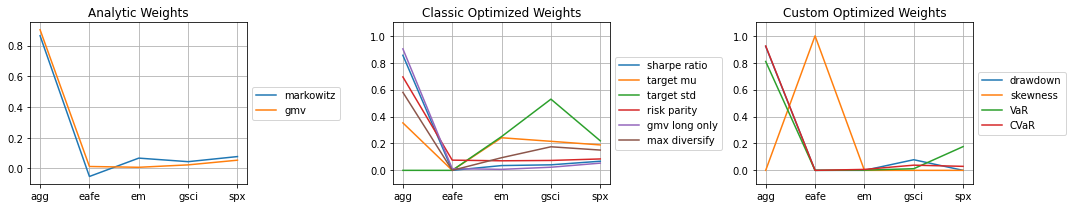

In [4]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.title("Analytic Weights")
plt.plot(cols, weight_generator.ls1_markowitz_weight(), label='markowitz')
plt.plot(cols, weight_generator.ls1_gmv_weight(), label='gmv')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid()

plt.subplot(1,3,2)
plt.title("Classic Optimized Weights")
plt.ylim((bnd[0]-0.1,bnd[1]+0.1))
plt.plot(cols, weight_generator.markowitz_weight_bnd_sr(), label='sharpe ratio')
plt.plot(cols, weight_generator.markowitz_weight_bnd_mu(target_mu = returns.mean().mean()), label='target mu')
plt.plot(cols, weight_generator.markowitz_weight_bnd_std(target_std = returns.std().mean()), label='target std')
plt.plot(cols, weight_generator.riskparity_weight(risk_weight = np.ones(returns.shape[1])/returns.shape[1]), label='risk parity')
plt.plot(cols, weight_generator.gmv_weight_bnd(), label='gmv long only')
plt.plot(cols, weight_generator.md_weight(), label='max diversify')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid()

plt.subplot(1,3,3)
plt.title("Custom Optimized Weights")
plt.ylim((bnd[0]-0.1,bnd[1]+0.1))
plt.plot(cols, weight_generator.custom_weight(drawdown_objective), label='drawdown')
plt.plot(cols, weight_generator.custom_weight(skewness_objective), label='skewness')
plt.plot(cols, weight_generator.custom_weight(varisk_objective, add=[0.1]), label='VaR')
plt.plot(cols, weight_generator.custom_weight(cvarisk_objective, add=[0.1]), label='CVaR')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid()

plt.tight_layout()
plt.savefig('weights_example.png',dpi=200)

## 2. covariance matrices

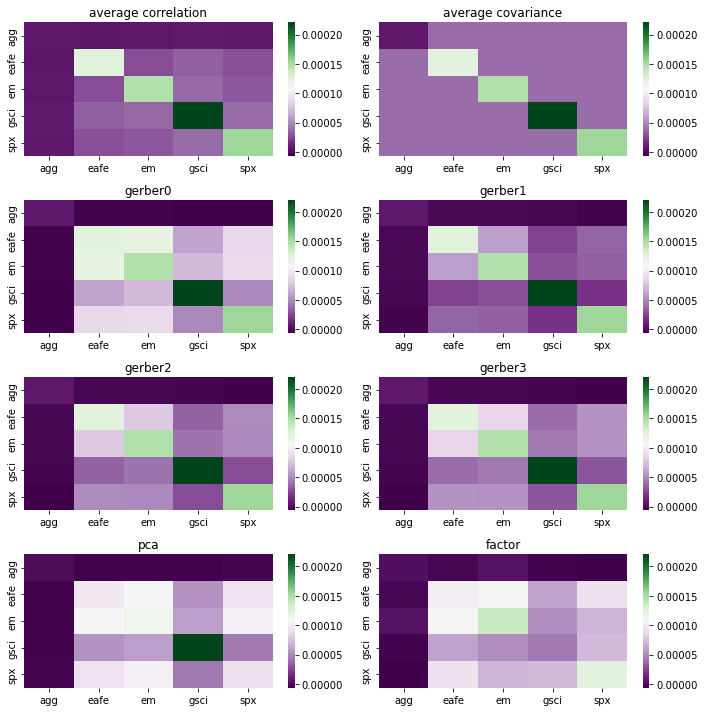

In [5]:
corr, cov_corr = avg_corr(returns)
corr, cov_cov = avg_cov(returns)
corr, cov_g0 = gerber_cov_stat0(np.array(returns))
corr, cov_g1 = gerber_cov_stat1(np.array(returns))
corr, cov_g2 = gerber_cov_stat2(np.array(returns))
corr, cov_g3 = gerber_cov_stat3(np.array(returns))
corr, cov_pca = pca_cov(returns = returns, threshold=0.6)

# creating a random factor series...
factor_num = 2
w = np.random.random((returns.shape[1],factor_num))
w = w/w.sum(0)
factors = returns @ w + returns @ w
corr, cov_factor = factor_cov(returns = returns, factors=factors)

cov_dict = {'average correlation': cov_corr, 'average covariance': cov_cov,
            'gerber0': cov_g0, 'gerber1': cov_g1, 'gerber2': cov_g2, 'gerber3': cov_g3,
            'pca': cov_pca, 'factor': cov_factor}
plt.figure(figsize=(10,10))
for e,k in enumerate(cov_dict.keys()):
    plt.subplot(4,2,e+1)
    plt.title(k)
    sns.heatmap(cov_dict[k], cmap="PRGn",
                vmin=np.array(returns.cov()).min(),
                vmax=np.array(returns.cov()).max(),
                xticklabels=cols, yticklabels=cols)
plt.tight_layout()
plt.savefig('covariance_example.png',dpi=100)

## 3. sample metrics and efficient frontier
* classic [standard deviation] ~ [returns]
* and other metrics in line with the porfolios generated
* mutli-dimensional efficient frontier

In [6]:
weights = []
df = pd.DataFrame(columns = ['returns','std','sharpe','weight_sq','mdd','skew','VaR','CVaR'])
pf_r = [] # returns
pf_std = [] # standard deviation
pf_sr = [] # sharpe ratio
pf_wsq = [] # sum of individual weight squared
pf_mdd = [] # max drawdown
pf_skew = [] # skewness
var_percentile = 0.05
pf_varisk = [] # value at risk
pf_cvarisk = [] # conditional value at risk


for i in np.linspace(returns.std().min(),returns.std().max(),100):
    w = weight_generator.markowitz_weight_bnd_std(target_std = i)
    weights.append(w)
    
    pf_r.append(returns.mean() @ w)
    pf_std.append(np.sqrt(w@returns.cov()@w.T))
    
    pf_wsq.append(np.sum(w**2))
    pf_mdd.append(drawdown_objective(w, [returns]))
    pf_skew.append(skewness_objective(w, [returns]))
    
    pf_varisk.append(varisk_objective(w, [returns, var_percentile]))
    pf_cvarisk.append(cvarisk_objective(w, [returns, var_percentile]))
    #plt.plot( i, weight_generator.markowitz_weight_bnd_std(target_std = i)   )

df['returns'] = pf_r
df['std'] = pf_std
df['sharpe'] = df['returns']/df['std']
df['weight_sq'] = pf_wsq
df['mdd'] = pf_mdd
df['skew'] = pf_skew
df['VaR'] = pf_varisk
df['CVaR'] = pf_cvarisk

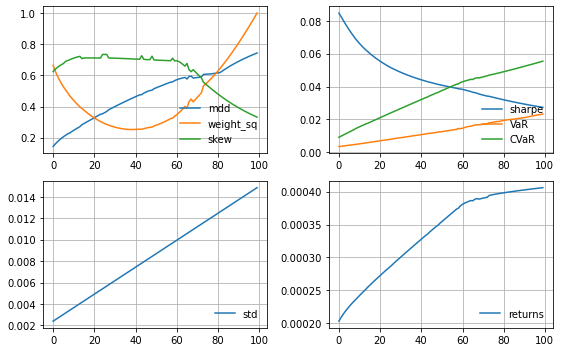

In [7]:
plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
for i in ['mdd','weight_sq','skew']: plt.plot(df[i], label=i)
plt.legend(loc='lower right', framealpha=0)
plt.grid()
plt.subplot(2,2,2)
for i in ['sharpe','VaR','CVaR']: plt.plot(df[i], label=i)
plt.legend(loc='lower right', framealpha=0)
plt.grid()
plt.subplot(2,2,3)
plt.plot(df[['std']], label='std')
plt.legend(loc='lower right', framealpha=0)
plt.grid()
plt.subplot(2,2,4)
plt.plot(df[['returns']], label='returns')
plt.legend(loc='lower right', framealpha=0)
plt.grid()
plt.tight_layout()
plt.savefig('metrics_example.png',dpi=200)

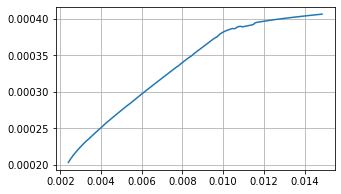

In [8]:
plt.figure(figsize=(5,3))
plt.plot(df['std'],df['returns'])
plt.grid()

In [9]:
fig = px.scatter_3d(df, x='mdd', y='std', z='returns', color='sharpe')
fig.show()

## 4. sample backtest

100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 201.42it/s]


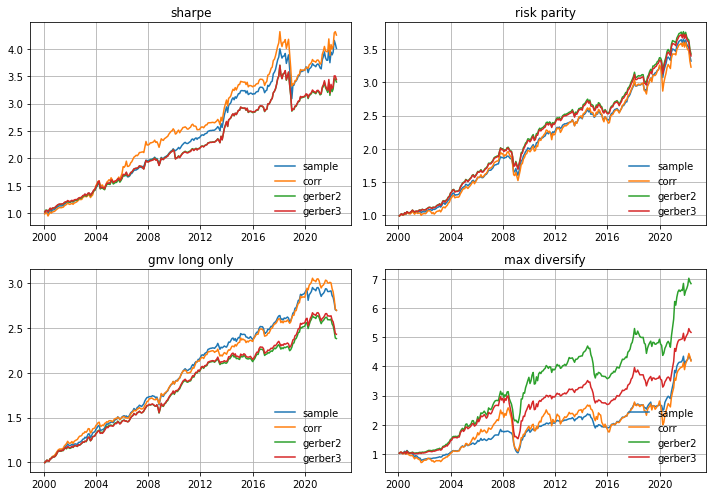

In [11]:
lookback = 12 # lookback in months
freq = 'M' # frequency of data to fit covariance and optimize
price_freq = price.resample(freq).last()
returns_freq = price_freq.pct_change(1).dropna()
returns_m = price.resample('M').last().pct_change(1).dropna() # monthly rebalance
lag = 1

plt.figure(figsize=(10,7))
for e,opt_type in enumerate(['sharpe','risk parity', 'gmv long only', 'max diversify']):
    weights_sample  = monthly_backtest_weights(returns=returns_freq, lookback=lookback, cov_type='sample', opt_type=opt_type,
                             bound = (0,1), net_weight = 1, risk_weight = np.ones(returns.shape[1])/returns.shape[1])

    weights_corr  = monthly_backtest_weights(returns=returns_freq, lookback=lookback, cov_type='avg_corr', opt_type=opt_type,
                             bound = (0,1), net_weight = 1, risk_weight = np.ones(returns.shape[1])/returns.shape[1])

    weights_gerber2  = monthly_backtest_weights(returns=returns_freq, lookback=lookback, cov_type='gerber2', opt_type=opt_type,
                             bound = (0,1), net_weight = 1, threshold=0.5, risk_weight = np.ones(returns.shape[1])/returns.shape[1])

    weights_gerber3  = monthly_backtest_weights(returns=returns_freq, lookback=lookback, cov_type='gerber3', opt_type=opt_type,
                             bound = (0,1), net_weight = 1, threshold=0.5, risk_weight = np.ones(returns.shape[1])/returns.shape[1])
    
    plt.subplot(2,2,e+1)
    plt.title(opt_type)
    plt.plot(np.cumprod(1+(returns_m.iloc[-len(weights_sample[:-lag]):,:] * weights_sample[:-lag]).sum(1)), label = 'sample')
    plt.plot(np.cumprod(1+(returns_m.iloc[-len(weights_corr[:-lag]):,:] * weights_corr[:-lag]).sum(1)), label = 'corr')
    plt.plot(np.cumprod(1+(returns_m.iloc[-len(weights_gerber2[:-lag]):,:] * weights_gerber2[:-lag]).sum(1)), label = 'gerber2')
    plt.plot(np.cumprod(1+(returns_m.iloc[-len(weights_gerber3[:-lag]):,:] * weights_gerber3[:-lag]).sum(1)), label = 'gerber3')
    plt.legend(loc='lower right', framealpha=0)
    plt.grid()
plt.tight_layout()
plt.savefig('backtest_example1.png',dpi=200)

100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:02<00:00, 107.43it/s]


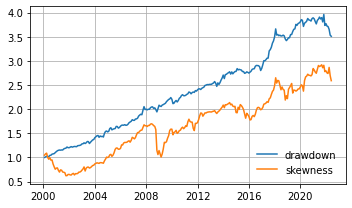

In [12]:
plt.figure(figsize=(5,3))
for opt_type in ['drawdown', 'skewness']:
    weights  = monthly_backtest_weights(returns=returns_freq, lookback=lookback, opt_type=opt_type,
                             bound = (0,1), net_weight = 1, add=[0.1])
    #plt.subplot(2,2,e+1)
    #plt.title(opt_type)
    plt.plot(np.cumprod(1+(returns_m.iloc[-len(weights[:-lag]):,:] * weights[:-lag]).sum(1)), label=opt_type)
plt.legend(loc='lower right', framealpha=0)
plt.grid()
plt.tight_layout()
plt.savefig('backtest_example2.png',dpi=200)